## STEP 4: DEVELOP A FUZZY LOGIC MODEL

A fuzzy logic model is one that is built on expert knowledge rather than
training data. You may wish to use the
[`scikit-fuzzy`](https://pythonhosted.org/scikit-fuzzy/) library, which
includes many utilities for building this sort of model. In particular,
it contains a number of **membership functions** which can convert your
data into values from 0 to 1 using information such as, for example, the
maximum, minimum, and optimal values for soil pH.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>To train a fuzzy logic habitat suitability model:</p>
<pre><code>1. Research S. nutans, and find out what optimal values are for each variable you are using (e.g. soil pH, slope, and current climatological annual precipitation). 
2. For each **digital number** in each raster, assign a **continuous** value from 0 to 1 for how close that grid square is to the optimum range (1=optimal, 0=incompatible). 
3. Combine your layers by multiplying them together. This will give you a single suitability number for each square.
4. Optionally, you may apply a suitability threshold to make the most suitable areas pop on your map.</code></pre></div></div>

> **Tip**
>
> If you use mathematical operators on a raster in Python, it will
> automatically perform the operation for every number in the raster.
> This type of operation is known as a **vectorized** function. **DO NOT
> DO THIS WITH A LOOP!**. A vectorized function that operates on the
> whole array at once will be much easier and faster.

<span style='color: purple'>

Optimal and tolerable ranges:

* Soil:
    * Optimal pH: 6.5
    * Tolerable range: 5.0 - 7.5
    * *Source:* https://www.fs.usda.gov/psw/publications/documents/psw_rp028/psw_rp028.pdf

* Elevation:
    * Optimal: 100 ft - 2,500 ft
    * Tolerable range: sealevel - 3,000 ft
    * *Source for both ranges:* https://www.fs.usda.gov/psw/publications/documents/psw_rp028/psw_rp028.pdf

* Average annual precipitation:
    * Optimal: 50 in - 70 in (1270 mm - 1800 mm)
        * It was difficult to find a description of an exact optimal range of precipitation for the coastal redwood, so I am using the mean precipitation values from two different sources. The 50 inch number is from [here](https://www.nps.gov/parkhistory/online_books/shirley/sec4.htm#:~:text=The%20main%20part%20of%20the,100%20inches%20of%20rainfall%20annually.) and the 70 inch number is from [here](https://www.fs.usda.gov/database/feis/plants/tree/seqsem/all.html#11). 
    * Tolerable range: [20 in - 200 in (508 mm - 5080 mm)](https://plants.usda.gov/plant-profile/SESE3/characteristics)
</span>

<span style='color: purple'>

Load in stored variables:

</span>

In [1]:
%store -r data_dir sites_gdf siskiyou_forest_gdf padres_forest_gdf
%store -r siskiyou_soil_ph_da padres_soil_ph_da
%store -r siskiyou_srtm_da padres_srtm_da
%store -r ave_annual_pr_das_list climate_df_list
%store -r siskiyou_elev_reproj_da padres_elev_reproj_da reproj_ave_annual_pr_das

<span style='color: purple'>

Import packages:

</span>

In [2]:
from math import floor, ceil

import cartopy.crs as ccrs
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import numpy as np
import rioxarray as rxr
import rioxarray.merge as rxrmerg
import skfuzzy as fuzz # Create fuzzy logic model
import xarray as xr

<span style='color:purple'>

## First look at suitability using boolean logic:

</span>

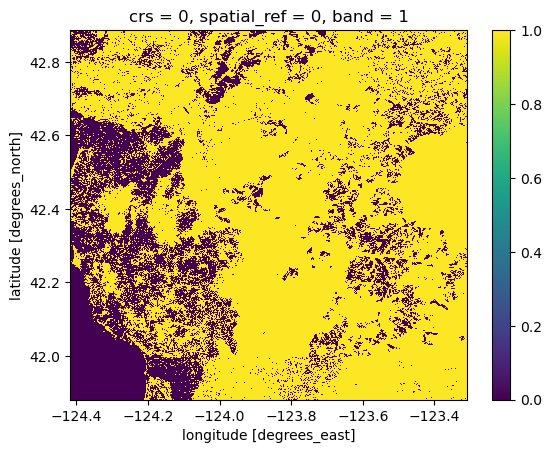

In [3]:
# use 'bitwise and' to see suitability of min and max precip values together
precip_suit = ((reproj_ave_annual_pr_das[0] > 508) & (reproj_ave_annual_pr_das[0] < 5080))

# use 'bitwise and' to see suitability of min and max pH values together
ph_suit = ((siskiyou_soil_ph_da > 5.0) & (siskiyou_soil_ph_da < 7.5))

# find suitability of precipitation and ph together
# this multiplies together each value of each suitability plot together
(precip_suit * ph_suit).plot()

<span style='color:purple'>

## Now look at suitability using fuzzy logic:

Going to use the trapezoidal membership function so that our optimal values have a range and or tolerable values have a range

</span>

In [4]:
# get details of trapmf function
help(fuzz.trapmf)

Help on function trapmf in module skfuzzy.membership.generatemf:

trapmf(x, abcd)
    Trapezoidal membership function generator.
    
    Parameters
    ----------
    x : 1d array
        Independent variable.
    abcd : 1d array, length 4
        Four-element vector.  Ensure a <= b <= c <= d.
    
    Returns
    -------
    y : 1d array
        Trapezoidal membership function.



<span style='color:purple'>

None of the values in the siskiyou_soil_ph_da are exactly 6.5, and I know that redwoods currently live in siskiyou, so instead of using a triangular membership function w/ one optimum value, we'll use a trapezoidal membership function and a range around 6.5.

First use trapezoidal membership function on soil_ph_das:
</span>

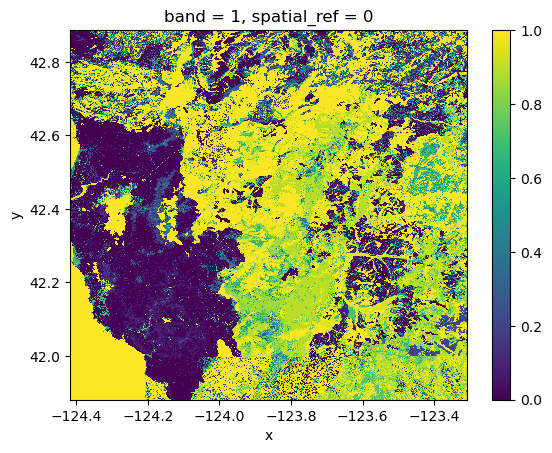

In [5]:
# save shape of siskiyou_soil_ph_da
shape = (siskiyou_soil_ph_da
         # .values leaves just an array, removes the xarray wrappers
         .values
         .shape)

# copy siskiyou_soil_ph_da to keep all coordinates, etc
siskiyou_ph_fuzz = siskiyou_soil_ph_da.copy()

# create membership function
siskiyou_ph_fuzz.values = (
    # reshape 1D array created below back to siskiyou_soil_ph_da shape
    np.reshape(
        fuzz.trapmf(
            # .flatten lays 2D array into 1D array
            siskiyou_soil_ph_da.values.flatten(),
            # pH tolerance and optimum values
            [5.0, 6.0, 7.0, 7.5]),
            shape
            )
        )
siskiyou_ph_fuzz.plot()

In [6]:
# COMMENTING OUT THIS WHOLE CELL FOR NOW SINCE IT IS CAUSING A MEMORY ERROR
# # save shape of padres_soil_ph_da
# padres_shape = (padres_soil_ph_da
#          # .values leaves just an array, removes the xarray wrappers
#          .values
#          .shape)

# # copy padres_soil_ph_da to keep all coordinates, etc
# padres_ph_fuzz = padres_soil_ph_da.copy()

# # create membership function
# padres_ph_fuzz.values = (
#     # reshape 1D array created below back to padres_soil_ph_da shape
#     np.reshape(
#         fuzz.trapmf(
#             # .flatten lays 2D array into 1D array
#             padres_soil_ph_da.values.flatten(),
#             # pH tolerance and optimum values
#             [5.0, 6.0, 7.0, 7.5]),
#             padres_shape
#             )
#         )
# padres_ph_fuzz.plot()

<span style='color:purple'>

Next use trapezoidal membership function on Siskiyou projected average annual precipitation in the 2050 time period for the CanESM2 model, reproj_ave_annual_pr_das[0].

</span>

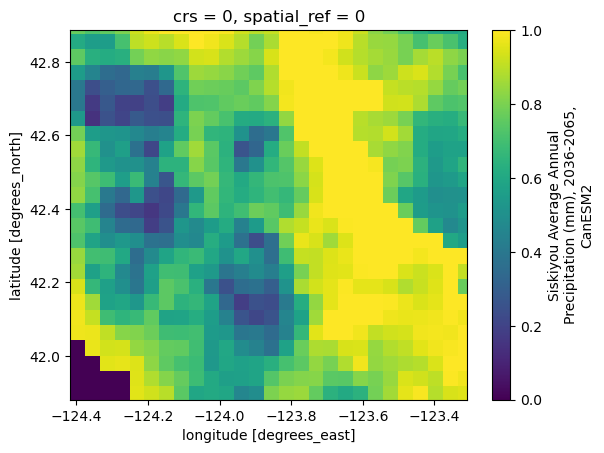

In [7]:
# save shape of reproj_ave_annual_pr_das[0]
siskiyou_pr_2050_CanESM2_shape = (reproj_ave_annual_pr_das[0]
         # .values leaves just an array, removes the xarray wrappers
         .values
         .shape)

# copy reproj_ave_annual_pr_das[0] to keep all coordinates, etc
siskiyou_pr_2050_CanESM2_fuzz = reproj_ave_annual_pr_das[0].copy()

# create membership function
siskiyou_pr_2050_CanESM2_fuzz.values = (
    # reshape 1D array created below back to reproj_ave_annual_pr_das[0] shape
    np.reshape(
        fuzz.trapmf(
            # .flatten lays 2D array into 1D array
            reproj_ave_annual_pr_das[0].values.flatten(),
            # pH tolerance and optimum values
            [508, 1270, 1800, 5080]),
            siskiyou_pr_2050_CanESM2_shape
            )
        )
siskiyou_pr_2050_CanESM2_fuzz.plot()

<span style='color:purple'>

Now do raster multiplication w/ siskiyou_ph_fuzz and siskiyou_pr_2050_CanESM2_fuzz (we may be able to do this with skfuzzy.fuzzy_mult() or another scikit fuzzy multiplication function, using normal multiplication for now):

</span>

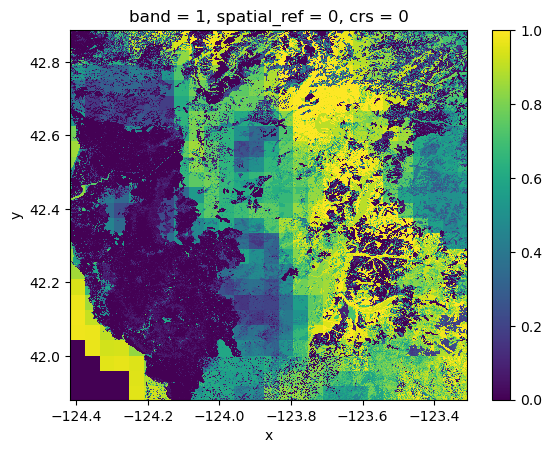

In [ ]:
# we could add robust=True inside the plot parentheses to make plot areas easier to see
(siskiyou_ph_fuzz * siskiyou_pr_2050_CanESM2_fuzz).plot()

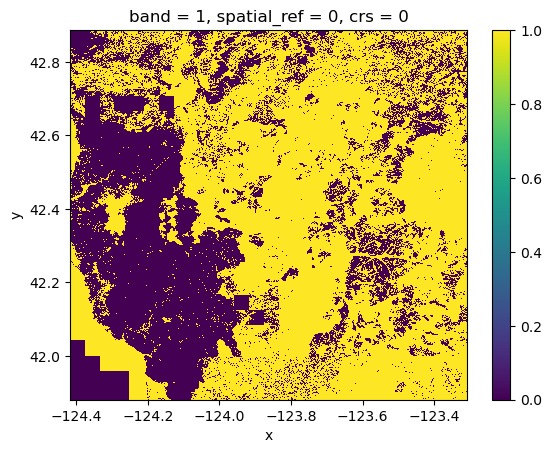

In [9]:
# set suitability threshold, change back to boolean logic
# for the ph and precip in the raster mult to be considered a suitabile habitat, their product has to be greater than .2
((siskiyou_ph_fuzz * siskiyou_pr_2050_CanESM2_fuzz) > .2).plot()

possible next step: use raster subtraction to subtract habitat suitability fuzzy logic models from the different time periods to see how much habitat suitability changes over time

<span style='color:purple'>

## Habitat suitability Fuzzy Logic for all climate model situations

Going to use the trapezoidal membership function so that our optimal values have a range and our tolerable values have a range

1. Create fuzzy models for each DataArray

    a. Add names to soil and elevation DataArrays

    b. Create a list of all DataArrays to loop through

    c. Make & use a function to create fuzzy models

2. Complete raster multiplication:

    a. Siskiyou pH fuzzy model * Siskiyou elevation fuzzy model * each of the four Siskiyou 2050 climate fuzzy models

    b. Siskiyou pH fuzzy model * Siskiyou elevation fuzzy model * each of the four Siskiyou 2080 climate fuzzy models
    
    c. Padres pH fuzzy model * Padres elevation fuzzy model * each of the four Padres 2050 climate fuzzy models

    d. Padres pH fuzzy model * Padres elevation fuzzy model * each of the four Padres 2080 climate fuzzy models

</span>

<span style='color:purple'>

Add names to soil and elevation DataArrays:

</span>

In [13]:
siskiyou_soil_ph_da.name = 'Siskiyou Soil pH'
siskiyou_elev_reproj_da.name = 'Siskiyou Elevation (m)'
padres_soil_ph_da.name = 'Los Padres Soil pH'
padres_elev_reproj_da.name = 'Los Padres Elevation (m)'

<span style='color:purple'>

Create a list of all DataArrays to loop through:

</span>

In [ ]:
das_list = [
    siskiyou_soil_ph_da,
    siskiyou_elev_reproj_da,
    padres_soil_ph_da,
    padres_elev_reproj_da,
    reproj_ave_annual_pr_das[0],
    reproj_ave_annual_pr_das[1],
    reproj_ave_annual_pr_das[2],
    reproj_ave_annual_pr_das[3],
    reproj_ave_annual_pr_das[4],
    reproj_ave_annual_pr_das[5],
    reproj_ave_annual_pr_das[6],
    reproj_ave_annual_pr_das[7],
    reproj_ave_annual_pr_das[8],
    reproj_ave_annual_pr_das[9],
    reproj_ave_annual_pr_das[10],
    reproj_ave_annual_pr_das[11],
    reproj_ave_annual_pr_das[12],
    reproj_ave_annual_pr_das[13],
    reproj_ave_annual_pr_das[14],
    reproj_ave_annual_pr_das[15]
    ]

In [18]:
das_list

[<xarray.DataArray 'Siskiyou Soil pH' (y: 3622, x: 3989)> Size: 58MB
 array([[4.900687 , 4.9083242, 4.9083242, ..., 6.064574 , 6.0503283,
               nan],
        [4.8496294, 5.064386 , 5.0651016, ..., 6.1050434, 5.9562616,
               nan],
        [4.8344727, 4.8875594, 4.83582  , ..., 5.9791656, 6.0053306,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 5.9569807, 5.984298 ,
               nan],
        [      nan,       nan,       nan, ..., 5.9737034, 6.02246  ,
               nan],
        [      nan,       nan,       nan, ..., 5.9786186, 5.9872603,
               nan]], dtype=float32)
 Coordinates:
   * x            (x) float64 32kB -124.4 -124.4 -124.4 ... -123.3 -123.3 -123.3
   * y            (y) float64 29kB 42.89 42.89 42.89 42.89 ... 41.88 41.88 41.88
     band         int64 8B 1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     _FillValue:     nan,
 <xarray.DataArray 'Siskiyou Elevation (m)' (y: 3622, x: 3989)>

<span style='color:purple'>

Siskiyou & Padres soil fuzzy models:

</span>

In [3]:
# save shape of siskiyou_soil_ph_da
shape = (siskiyou_soil_ph_da
         # .values leaves just an array, removes the xarray wrappers
         .values
         .shape)

# copy siskiyou_soil_ph_da to keep all coordinates, etc
siskiyou_ph_fuzz = siskiyou_soil_ph_da.copy()

# create membership function
siskiyou_ph_fuzz.values = (
    # reshape 1D array created below back to siskiyou_soil_ph_da shape
    np.reshape(
        fuzz.trapmf(
            # .flatten lays 2D array into 1D array
            siskiyou_soil_ph_da.values.flatten(),
            # pH tolerance and optimum values
            [5.0, 6.0, 7.0, 7.5]),
            shape
            )
        )

In [4]:
# save shape of padres_soil_ph_da
padres_shape = (padres_soil_ph_da
         # .values leaves just an array, removes the xarray wrappers
         .values
         .shape)

# copy padres_soil_ph_da to keep all coordinates, etc
padres_ph_fuzz = padres_soil_ph_da.copy()

# create membership function
padres_ph_fuzz.values = (
    # reshape 1D array created below back to padres_soil_ph_da shape
    np.reshape(
        fuzz.trapmf(
            # .flatten lays 2D array into 1D array
            padres_soil_ph_da.values.flatten(),
            # pH tolerance and optimum values
            [5.0, 6.0, 7.0, 7.5]),
            padres_shape
            )
        )

<span style='color:purple'>

Siskiyou & Padres elevation fuzzy models:

</span>

In [5]:
# save shape of siskiyou_srtm_da
s_elev_shape = (siskiyou_srtm_da
         # .values leaves just an array, removes the xarray wrappers
         .values
         .shape)

# copy siskiyou_srtm_da to keep all coordinates, etc
siskiyou_elev_fuzz = siskiyou_srtm_da.copy()

# create membership function
siskiyou_elev_fuzz.values = (
    # reshape 1D array created below back to siskiyou_srtm_da shape
    np.reshape(
        fuzz.trapmf(
            # .flatten lays 2D array into 1D array
            siskiyou_srtm_da.values.flatten(),
            # elevation tolerance and optimum values
            [0, 100, 2500, 3000]),
            s_elev_shape
            )
        )

In [6]:
# save shape of padres_srtm_da
p_elev_shape = (padres_srtm_da
         # .values leaves just an array, removes the xarray wrappers
         .values
         .shape)

# copy padres_srtm_da to keep all coordinates, etc
padres_elev_fuzz = padres_srtm_da.copy()

# create membership function
padres_elev_fuzz.values = (
    # reshape 1D array created below back to padres_srtm_da shape
    np.reshape(
        fuzz.trapmf(
            # .flatten lays 2D array into 1D array
            padres_srtm_da.values.flatten(),
            # elevation tolerance and optimum values
            [0, 100, 2500, 3000]),
            p_elev_shape
            )
        )